Authors: [Davide](https://www.kaggle.com/daviderigon), [Pierfrancesco](https://www.kaggle.com/pier994), [Stefano](https://www.kaggle.com/stefanocallegaro)

<a id = "ToC">Table of Contents</a>
1. [Configuration](#step1)
2. [Model Architecture](#step2)
3. [DataSet and DataLoader](#step3)
4. [Training](#step4)
5. [Ensembling & Evaluation](#step5)
5. [Submission](#step6)

In [ ]:
# 1. Standard Libraries
import time
from collections import OrderedDict
from pathlib import Path
import copy

# 2. Third party modules

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# 2.1 Deep Learning dependencies

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

# 2.2 Machine Learning dependencies

from sklearn.model_selection import StratifiedKFold

### <a id = "step1">Step1. Configuration</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

First thing first: let's define the parameters/hyperparameters that are going to be used in different stages of the script.

In particular:
* **device:** it is used to define the device on which the model is going to be trained (GPU/CPU);  
* **base_path:** the path to all the input of the competition;
* **images_path:** the path to training images;
* **size_crop:** the preprocessing of the images produces a cropped output. This parameter uniquely identifies the dimension of the images as input of the model. In particular, after data preprocessing, the image is described with the following number of features (pixels): $$size(processed\_image) = num\_channels (RGB) * height * width = 3 \cdot size\_crop\cdot size\_crop $$  
* **num_epochs, folds, batch_size_train, batch_size_valid:** first thing first, let's visualize what the training process looks like
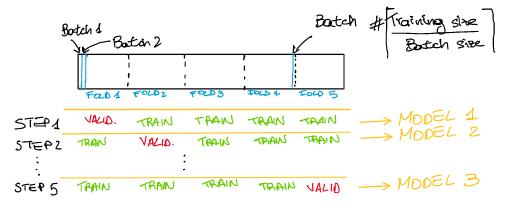
What is going on? First of all, images are shuffled and divided in a given number of folds, that is specified by **folds** parameter. Implicitly, this parameter tells us how many models are build in this script. This is because the algorithm iterates over all different folds, creating a different training-validation partitioning every time. In particular, for each iteration, the training set is built by selecting all folds but the selected one. On the other hand, the excluded fold is used as the validation set.  
**Fine, and what about the training procedure of each model?** Once the *training* data have been defined, these have to be divided in small chunks called *batches*. This is crucial, since it allows to reduce the amount of information (data and gradients) to store in the RAM. In other words, if this step was skipped, the script would get an error because of memory issue. The size of these chunks is referred to as *batch_size*, and I decided to set a different value for training and validation. This is because validation set is not used to update parameters, thus storing the gradients is not needed. By saving memory, the validation batch size can be increased. **Epoch** parameter states how many times the model has to be trained on each batch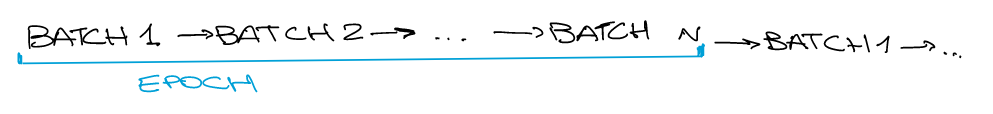


* **lr_transfer, lr_train:** this parameters are usually defined as a single one, the learning rate. Here we decided to define two different parameters in order to handle transfer learning properties correctly. For further information, please refer to [training section](#transfer_lr);

* **num_workers:** even though the model should be trained using GPU, there is an important step in which the CPU plays a key role: feeding the GPU with new (augmented) data. This is achieved by using *DataLoader* PyTorch operator, and it is one of the slowest step of the entire script. Hence, it is important to speed it up as much as possible. I tried different strategies (you can play with *pin_memory* parameter as suggested by official documentation), and I rekon that increasing the number of workers as much as possible is the best (and most common) way to proceed.

In [ ]:
CFG = {"device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
       "base_path": '/kaggle/input/cassava-leaf-disease-classification/',
       "images_path": "/kaggle/input/cassava-leaf-disease-classification/train_images",
       "size_crop": 500,
       "num_epochs": 1, # this should be set as an integer greater than 0. I usually go for 8 in this king of notebook
       "folds": 5,
       "lr_transfer": 1e-4,
       "lr_train": 5e-4,
       "batch_size_train": 64,
       "batch_size_valid": 300,
       "num_workers": 4}

## <a id = "step2">Step2. Model Architecture</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

<a id = "transfer_lr"><b>Network Architecture:</b></a>

In order to understand how and why we decided to define the architecture of the model in this way, the concept of *transfer learning* needs to be clarified.  

Suppose that we have access to a model that has been trained on a huge dataset with input data same structure similar to the structure of the data we are working with. Hence, for this particular competition, suppose we can pick a model that has been trained on images. Its structure is something like this:

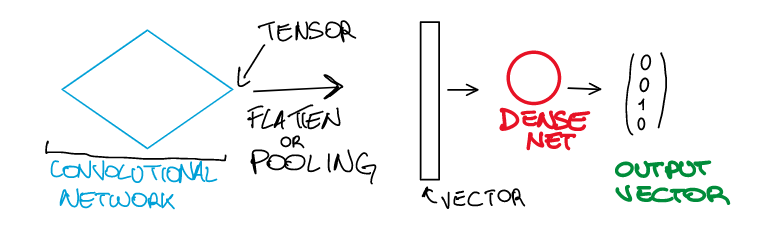
We can think of this architecture as splitted in two parts. The first one is a convolutional network catching primitive features from the image, like colors, corners, edges, gradients. Once this low level piece of information has been found, it can be represented as a vector by flattening or pooling. Eventually, a simple dense network takes this feature vector as input and computes an output accordingly.  


But why should we care about that? 
Of course, the dense network is task-specific, and it is not suitable for cassava leaf desease classification. However, the convolutional part is trained to catch low level features and this is not task-specific! Thus the idea is to take the first part of the baseline network and *transfer* it to our model. Afterward, a new (cassava leaf disease specific-) classification layer can be built on top of that. The new structure of the network will look like:

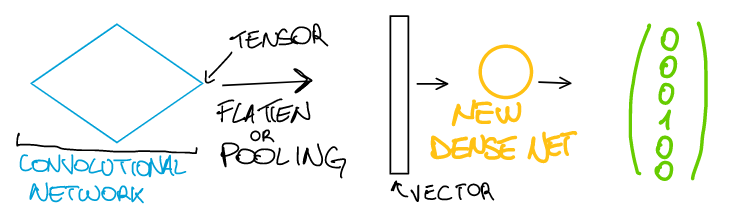

**Weights initialization:**

We create the classification sub-model by building a custom *Classifier* class. Here the deal is how the weights of the two linear layers are initialized. Bad initialization distribution will lead the model to poor performance. In particular, PyTorch library initialize all weight through the following distribution: $$U(-\sqrt{InputFeatures}, \sqrt{InputFeatures})$$
But there are other choices we can make for this initialization distribution. In particular in this notebook I would suggest to work with Kaiming normal distribution initialization for linear Layers.  
  
[For more in depth details, please refer to this wonderful post](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

In [ ]:
# First of all, import the pre trained model

model = models.resnet50(pretrained = True)

# Then, define the two layers I am going to use for classification purpose

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


class Classifier(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        self.layer1 = nn.Flatten()
        self.layer2 = nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.layer3 = nn.Dropout(p=0.25, inplace=False)
        self.layer4 = nn.Linear(in_features=4096, out_features=5, bias=True)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return(x)

# Definition of the function that initialize the weights for classification layer correctly
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)    
    
# Eventually, we can extrapolate the convolutional part of the transferred model

layers = list(model.children())[:-2]

In [ ]:
# Initialize the model

net = Classifier()
net.apply(init_weights)

layers_model = layers.copy()

resnet = nn.Sequential(*layers_model)

base_model = nn.Sequential(OrderedDict([
                                  ("ResNet", resnet),
                                  ("Pooling", AdaptiveConcatPool2d()),
                                  ("Classifier", net)
                                  ])) 

## <a id = "step3">Step 3. DataSet and DataLoader</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

**Introduction:** in this section we are going to define and process everything concerned with data. The purpose of the this step is to import data and build utility functions for data ingestion.  
The steps are:
* **Define a data augmentation framework:** we are going to build a function for data in the training set and one other for data in validation/test set. The reason is that we want to enlarge the variance of the data seen by the model as input, in order to reduce overfitting. On the other hand, we do not want the model to see a distort input when testing is coming in place;
* **Create and assign a fold index to each data point** 
* **Define DataLoader:** every deep learning model wants two elements as input, that is a batch of input data and the corresponding labels. In order to do that, PyTorch provides us a nice functionality, the dataloader object, that receives as input the *data*, and returns a generator of (batch_input, batch_target) data. This is particularly helpful because in this way, data has not to be memorized in the RAM, but it stays *on the fly* and it is loaded for every batch iteration during training. In particular, think about this situation, where we have a lot of images and it is helpful to use them only when needed, for memory optimization reasons;
* **Define a DataSet:** but there is one thing that I did not mention. What actually is *data*? It might seem a trivial question, but the data is usually preprocessed before being used as batch input. Moreover, DataLoader objects do not accept just *lists*, nor *arrays* and *tensors*. They require DataSet (that is, an object belonging to a subclass of *torch.utils.data.Dataset*) objects as input. And we could decide to use pre defined PyTorch datasets or to define a customized DataSet class. To do so, we need to instantiate a class with the __init__, __len__ and __getitem__ methods. In particular, in the getitem method we can specify how to preprocess the input (here is where we should define the data augmentation step).

[For further information on Datasets and Dataloader](https://medium.com/swlh/pytorch-dataset-dataloader-b50193dc9855)  
[Official PyTorch documentation](https://pytorch.org/docs/stable/data.html)

Notice that the data is not directly generated in this section, but it is itertively defined in [training](#step4) section. This is because the data that need to be actually generated depend on which folds are used as training set and on the batch.

In [ ]:
# Import the data frame containing indices and labels

df = pd.read_csv(CFG["base_path"] + 'train.csv',
                 dtype = {"label": "str"}
                )

df.head()

In [ ]:
# Split data into folds

splitter = StratifiedKFold(n_splits = CFG["folds"],
                shuffle = True
                )

In [ ]:
# Assign a fold index to each data point

for k, (i,j) in enumerate(splitter.split(df.image_id, df.label)):
    df.loc[j, "fold"] = k
    print(df.loc[i, "label"].value_counts())
    
df["fold"] = df["fold"].astype("int8")

### Augmentation Transformation 

In [ ]:
# Define data augmentation procedure. One for training and one for validation data

def get_train_aug(sz): return albumentations.Compose([
            albumentations.RandomResizedCrop(sz,sz),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

def get_valid_aug(sz): return albumentations.Compose([
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], p=1.)


## Data

In [ ]:
# This Dataset object allows to 

class Dataset(torch.utils.data.Dataset):
    """Class built on top of torch Dataset class. It is required to build a data loader in PyTorch.
       Dataset objects need to have a __len__ and a __getitem__ method
    """

    def __init__(self, list_IDs, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.list_IDs = list_IDs
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):

        ID = self.dataframe.loc[self.list_IDs[index], "image_id"]

        if self.transform:
            X = self.transform(image = np.array(Image.open(Path(self.base_path) / ID)))["image"].reshape((3, CFG["size_crop"], CFG["size_crop"]))
        else:
            X = transforms.ToTensor()(Image.open(Path(self.base_path) / ID))
        y = torch.tensor(np.array(self.dataframe.loc[self.list_IDs[index], "label"], dtype = "int"))

        return X, y

## <a id = "step4">Training</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

In the following two cells, the loss function, the optimizer and the learning rate scheduler are going to be defined.  
* **Loss Function:** we are going to use gold old cross entropy loss function. However, we need to use weights because of class imbalance in this dataset. As we know, more than 60% of data points fall in one single class. This means that the model is able to achieve a quite low value of the loss function just by predicting always the same class. You can try, but without weight the model will almost always predict the same class. The mathematical formulation of the new loss function is: $$\frac{weight\cdot CrossEntropyLoss}{mean(weight)}$$ where $weight$ is the vector of weights and $CrossEntropyLoss$ if the vector of the Cross Entropy loss (it will be made up by 0s, except for the coordinate of the true target);
* **Optimizer:** notice that it has been two set of parameters with different learning rates. This means that the algorithm is going to perform discriminative learning. In particular, the layers referred to the transfer learning part have been assigned a low learning rate, whereas the classification layers have an higher lr (*they have to be assessed*);
* **Learning rate scheduler:** it is the framework that each learning rate must follow. The idea behing learning rate sceduling is that in the first epochs, the learning rate should be higher in order to be able to find a local minimum area. On the other hand, later epochs should have a lower learning rate in order to find more precisely where the local minimum exactly is. We decided to use a cyclic learning rate in order to find a bunch of local minima (possibily not that accurate) in order to use all intermediate parameters found to produce an ensemble of learners.

[Refer to this post to have a look on other possible learning rate schedulers](https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling)

In [ ]:
for idx_fold in range(CFG["folds"]):
    
    # Definition of training and validation set
    
    idxs_train = df[df.fold != idx_fold].index
    idxs_valid = df[df.fold == idx_fold].index

    training_set = Dataset(idxs_train, df, CFG['images_path'], get_train_aug(CFG["size_crop"]))
    training_generator = torch.utils.data.DataLoader(training_set, 
                                                     batch_size = CFG["batch_size_train"], 
                                                     num_workers = CFG["num_workers"])

    validation_set = Dataset(idxs_valid, df, CFG["images_path"], get_valid_aug(CFG["size_crop"]))
    validation_generator = torch.utils.data.DataLoader(validation_set, 
                                                       batch_size = CFG["batch_size_train"],
                                                       num_workers = CFG["num_workers"])
    generators = {"train": training_generator,
              "valid": validation_generator}
    
    # Initialize the model

    # I need to build a deep copy of the model. 
    # Otherwise, models of different folds are not 
    # independent from each other
    
    model = copy.deepcopy(base_model)   

    # Since we are working with an imbalanced dataset, we assign a weight
    # to the loss contribution of each class. In other words,
    # classes with lower cardinality have an higher way, allowing
    # each class to have the same impact on the loss function
    
    weights = torch.from_numpy(df.label.value_counts().min()/df.label.value_counts().reset_index().sort_values("index")["label"].values).float()
    weights = weights.to(CFG["device"])
    loss_func = nn.CrossEntropyLoss(weight = weights, reduction = "mean")

    ### Optimizer
    
    optimizer = torch.optim.Adam([
                                     {"params": model.ResNet.parameters(), "lr": CFG["lr_transfer"], "weight_decay": 1e-6}, # I should set an Hyperparameter for the learning rate
                                     {"params": model.Classifier.parameters(), "lr": CFG["lr_train"], "weight_decay": 1e-6}
                                 ])
    scaler = GradScaler()
    
    ### Learning Rate Scheduler
    
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG["num_epochs"], T_mult=1, eta_min=0.00001, last_epoch=-1)

    model = model.to(CFG["device"])

    for epoch in range(CFG["num_epochs"]):


        print("-" * 15 + "Epoch: " + str(epoch + 1) + " / " + str(CFG["num_epochs"]) + "-" * 15)

        l = 0
        for step in ["train", "valid"]:
            if step == "train":
                print("Computing training epoch")
                model = model.train()
                for data, target in tqdm(generators[step], total = len(generators[step])):
                    data = data.to(CFG["device"])
                    target = target.to(CFG["device"])
                    
                    with autocast(): 
                        
                        ## autocast + GradScaler allow the training phase to work on a float16 precision  
                        ## This allows to double the batch size and speed up training
                        
                        pred = model(data)

                        loss = loss_func(pred, target)

                    # Back-propagation and gradient descent step
                    
                    for param in model.parameters():
                        param.grad = None
                    scaler.scale(loss).backward()

                    scaler.step(optimizer)
                    scaler.update()
                    l += loss.item()
                print(f"Mean loss function on training set: {round(l/len(generators[step]), 5)}")

            else:

                print("Computing validation accuracy")

                model = model.eval()
                num_correct = 0
                num_samples = 0

                for data, target in tqdm(generators[step], total = len(generators[step])):

                    data = data.to(CFG["device"])
                    target = target.to(CFG["device"])

                    with torch.no_grad():
                        predictions = model(data).max(axis = 1)[1]
                        num_correct += (predictions == target).sum().item()
                        num_samples += predictions.size(0)

                print(f"Validation accuracy: {round(100 * num_correct/num_samples, 2)}%")
                
                lr_scheduler.step()        
                
    checkpoint = {"state_dict": model.state_dict()}
    torch.save(checkpoint, f"checkpoint_fold_{idx_fold}.pth.tar")
    del model, optimizer, lr_scheduler
    torch.cuda.empty_cache()
    
del data, target
torch.cuda.empty_cache()

## <a id = "step5">Ensembling & Evalutation</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

An improvement to model performance can be achieved by combining the results of multiple (and independent) models. This technique is widely used in Machine Learning (you can think about XGBoost and Random Forest for example). Here you can find a simple ensembling of the models trained in the cell above. The output is computed by looking at the feature that has the overall higher shared confidence among models. However you can play around it. Here are a couple of suggestions:
* use normalized (through softmax) predictions instead of the model outputs;
* build a meta model (a dense neural network) that takes as input the stacked outputs of the models (normalized via softmax) and train it for leaf desease classification

In [ ]:
class Ensemble(nn.Module):
    def __init__(self):
        super(Ensemble, self).__init__()
        
        with open('checkpoint_fold_0.pth.tar', "rb") as f:
            state = torch.load(f)
        base_model.load_state_dict(state["state_dict"])    
        self.model1 = copy.deepcopy(base_model)
        self.model1 = self.model1.eval()
        with open('checkpoint_fold_1.pth.tar', "rb") as f:
            state = torch.load(f)
        base_model.load_state_dict(state["state_dict"])
        self.model2 = copy.deepcopy(base_model)
        self.model2 = self.model2.eval()
        with open('checkpoint_fold_2.pth.tar', "rb") as f:
            state = torch.load(f)
        base_model.load_state_dict(state["state_dict"])
        self.model3 = copy.deepcopy(base_model)
        self.model3 = self.model3.eval()
        with open('checkpoint_fold_3.pth.tar', "rb") as f:
            state = torch.load(f)
        base_model.load_state_dict(state["state_dict"])
        self.model4 = copy.deepcopy(base_model)
        self.model4 = self.model4.eval()
        with open('checkpoint_fold_4.pth.tar', "rb") as f:
            state = torch.load(f)
        base_model.load_state_dict(state["state_dict"])
        self.model5 = copy.deepcopy(base_model)
        self.model5 = self.model5.eval()
        
    def forward(self, x): 
        o1 = self.model1(x)
        o2 = self.model2(x)
        o3 = self.model3(x)
        o4 = self.model4(x)

        return o1 + o2 + o3 + o4
                                                     
ensemble = Ensemble()
ensemble = ensemble.to(CFG["device"])
emsemble = ensemble.eval()

## <a id = "step6"> Submission</a>  
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    """Class built on top of torch Dataset class. It is required to build a data loader in PyTorch.
       Dataset objects need to have a __len__ and a __getitem__ method
    """

    def __init__(self, list_IDs, transform=None):
        self.list_IDs = list_IDs
        self.transform = transform

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):

        ID = self.list_IDs[index]

        if self.transform:
            X = self.transform(image = np.array(Image.open(Path('/kaggle/input/cassava-leaf-disease-classification/test_images') / ID)))["image"].reshape((3, CFG["size_crop"], CFG["size_crop"]))

        else:
            X = transforms.ToTensor()(Image.open(Path(ID)))

        return X

In [ ]:
img_path = list(Path('/kaggle/input/cassava-leaf-disease-classification/test_images').glob("*"))

def clean_path(s):
    path = str(s)
    return path.split('/kaggle/input/cassava-leaf-disease-classification/test_images/')[1]

imagesPath = list(map(clean_path, img_path))

In [ ]:
test_set = TestDataset(imagesPath, get_valid_aug(CFG["size_crop"]))
test_generator = torch.utils.data.DataLoader(test_set, batch_size = CFG["batch_size_valid"], num_workers = 2)

In [ ]:
torch.cuda.empty_cache()
for i in test_generator:
    with torch.no_grad():
        i = i.to(CFG["device"])
        pred = ensemble(i)
    try:
        output = torch.cat((output, pred.max(axis = 1)[1].cpu()))
    except:
        output = pred.max(axis = 1)[1].cpu()
        
output_df = pd.DataFrame({
    'image_id' : imagesPath,
    'label' : output.numpy()
})

csv = output_df[['image_id', 'label']]
csv.to_csv('submission.csv', index = False)